<a href="https://colab.research.google.com/github/m-a-hasan/ai-colab/blob/main/05_transfer_learning_with_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For fine tuning, we can train only top 1 - 3 layers. Others will remain frozen.

In [ ]:
!nvidia-smi

Mon Oct 31 04:44:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get helper function to re-use
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-10-31 04:44:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-31 04:44:22 (88.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Download image data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-10-31 04:44:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   196MB/s    in 0.8s    

2022-10-31 04:44:26 (196 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through dirs and list files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# Create test and train directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

To generate images, we can use 2 different functions. First one we have used so far, 2nd one we will use in this tutorial. 2nd way is faster.


1.   ImageDataGenerator -> flow_from_directory()
2.   tf.keras.preprocessing.image_dataset_from_directory()



In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            label_mode="categorical",
                                                                            batch_size=32,
                                                                            image_size=IMG_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model (keep the pre-trained patterns)
base_model.trainable = False

# Create inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Efficientnet doesn't require values to be within 0 and 1 (normalized), but resnet needs it. We'll use efficientnet
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# pass the inputs
x = base_model(inputs)

# Print data shape
print(f"shape after base model: {x.shape}")

# Pooling average of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after GlobalAveragePooling: {x.shape}")

# Output activation layer
outputs = tf.keras.layers.Dense(10,
                                activation="softmax",
                                name="output_layer")(x)

# Create model
model_0 = tf.keras.Model(inputs, outputs)

# Compile
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=len(test_data_10_percent),
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16705208/16705208 [==============================] - 0s 0us/step
shape after base model: (None, 7, 7, 1280)
shape after GlobalAveragePooling: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20221031-044437
Epoch 1/5
24/24 [==============================] - 23s 417ms/step - loss: 1.8762 - accuracy: 0.4067 - val_loss: 1.3056 - val_accuracy: 0.7292
Epoch 2/5
24/24 [==============================] - 8s 325ms/step - loss: 1.0981 - accuracy: 0.7547 - val_loss: 0.8751 - val_accuracy: 0.8188
Epoch 3/5
24/24 [==============================] - 8s 328ms/step - loss: 0.7930 - accuracy: 0.8173 - val_loss: 0.6989 - val_accuracy: 0.8460
Epoch 4/5
24/24 [==============================] - 8s 327ms/step - loss: 0.6389 - accuracy: 0.8547 - val_loss: 0.6065 - val_accuracy: 0.8596
Epoch 5/5
24/24 [==============================] - 9s 371ms/step - loss: 0.5503 - accuracy: 0.8720 - val_loss: 0.5545 - val_accuracy: 0.8640


Here, we passed our custom data to already pre-trained Efficientnet model and asked "what pattern do you see" and then put our output layer on top to make sure the output was tailored to our desired classes.

In [ ]:
# Check layers in our model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Overall model has 5 layers, but one of those layers (efficientnetb0) has 236 layers within it

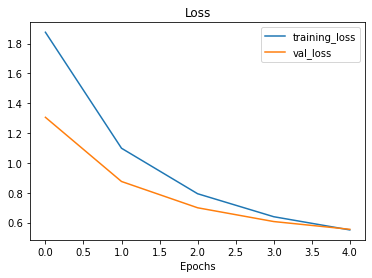

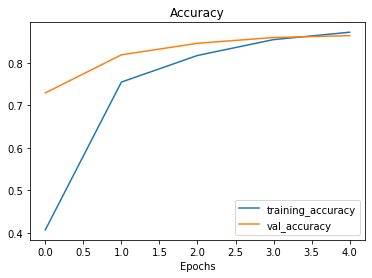

In [ ]:
plot_loss_curves(history_10_percent)

Test what GlobalAveragePooling2D does (flattens tensor to 2D after averaging the values)

In [ ]:
input_shape = (1, 4, 4, 3)

# Create random tensor
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: {input_tensor}\n")

# Pass input_tensor through 2D Pooling
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Random tensor after 2D Pooling: {global_average_pooled_tensor}\n")

# Check the shapes
print(f"Shape of the input: {input_tensor.shape}\n")
print(f"Shape of tensor after 2D pooling: {global_average_pooled_tensor.shape}")

Random input tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Random tensor after 2D Pooling: [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of the input: (1, 4, 4, 3)

Shape of tensor after 2D pooling: (1, 3)


Next 4 experiments -


1. model_1 = Feature extraction + 1% data + augmented data
2. model_2 = Feature extraction + 10% data + augmented data
3. model_3 = Fine tune + 10% data + augmented data
4. model_4 = Fine tune + 100% data + augmented data



In [ ]:
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Directories
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2022-10-31 04:45:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 209.85.234.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   180MB/s    in 0.7s    

2022-10-31 04:45:44 (180 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Walk through dir
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

Load data

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Augment Data
- Instead of using ImageDataGenerator, we'll augment data in the model layer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

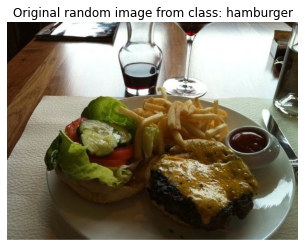

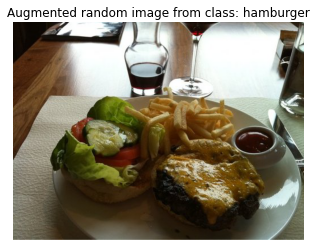

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

MODEL 1

In [ ]:
from tensorflow.python import training
# Freezing base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation layer
x = data_augmentation(inputs)

# Give base_model input after augmentation without training
x = base_model(x, training=False)

# Pool output features
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create a dense output layer
outputs = layers.Dense(10,
                       activation="softmax",
                       name="output_layer")(x)

# Create model
model_1 = keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25* len(test_data)), # evaluate on 25% of test data so the epochs run faster and we get a sense of how model is doing
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221031-044548
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.4506 - accuracy: 0.0714 - val_loss: 2.2388 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1219 - accuracy: 0.2000 - val_loss: 2.1246 - val_accuracy: 0.2220
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0076 - accuracy: 0.3286 - val_loss: 2.0001 - val_accuracy: 0.3207
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7701 - accuracy: 0.5429 - val_loss: 1.9006 - val_accuracy: 0.3832
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6222 - accuracy: 0.6429 - val_loss: 1.8012 - val_accuracy: 0.4490


With only 7 images, we got 50% accuracy

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

It shows we embedded data augmentation layer. Benefit of this is, if we save and load the model - data augmentation comes with it.

Let's run the evaluation on the complete set of test data

In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 1.8006 - accuracy: 0.4428


[1.8006194829940796, 0.44279998540878296]

Loss curves

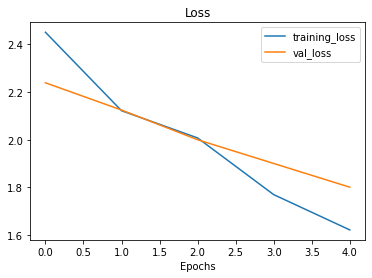

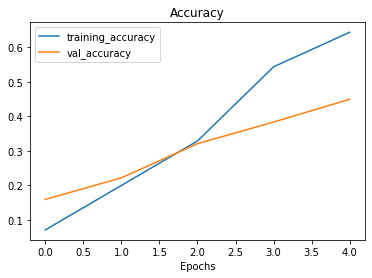

In [ ]:
plot_loss_curves(history_1_percent)

Model 2: Use 10% of augmented data

In [ ]:
# We already got the zip for 10 percent of 10 food classes. If not, run below code
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


Dataloader

In [ ]:
# Setup input
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Create model with data augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
    # use rescaling if using resnet
], name="data_augmentation")

input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

Model Checkpoint Callback



In [ ]:
# Create checkpoint path
checkpoint_path = "10_percent_model_checkpoint_weights/checkpoint.ckpt"

#Create callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # False will save the entire model
                                                         save_best_only=False, # True will save the best model instead of every epoch
                                                         save_freq="epoch",
                                                         verbose=1)

The SavedModel format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

In [ ]:
# Fit model with checkpoint
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221031-044632
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9814 - accuracy: 0.3387
Epoch 1: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 20s 559ms/step - loss: 1.9814 - accuracy: 0.3387 - val_loss: 1.4406 - val_accuracy: 0.6661
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3056 - accuracy: 0.7160
Epoch 2: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 12s 477ms/step - loss: 1.3056 - accuracy: 0.7160 - val_loss: 0.9897 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.7693
Epoch 3: saving model to 10_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 10s 425ms/step - loss: 0.9911 - accuracy: 0.7693 - val_loss: 0.7818 - val_accuracy: 0.8207
Epoch 4

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6173 - accuracy: 0.8432


[0.617347776889801, 0.8432000279426575]

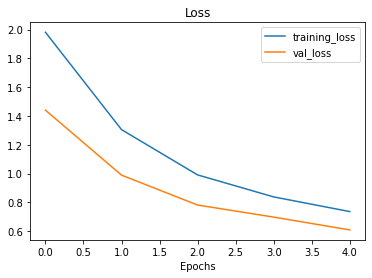

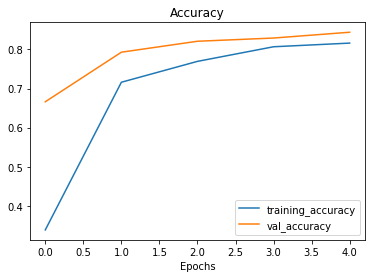

In [ ]:
# Loss curves
plot_loss_curves(history_10_percent_data_aug)

Load checkpoint model

In [ ]:
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

# Compare the results before and after loading
results_10_percent_data_aug, loaded_weights_model_results

79/79 [==============================] - 6s 73ms/step - loss: 0.6173 - accuracy: 0.8432


([0.617347776889801, 0.8432000279426575],
 [0.6173475980758667, 0.8432000279426575])

Fine-tuning existing model on 10% of the data
- Fine tuning means layers closer to the input layer stay frozen and layer closer the output layer gets updated during training

In [ ]:
# Check model_2 layers
model_2.layers

In [ ]:
# Check which layers are trainable
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


- Layer 1 - input layer - trainable
- Layer 2 - Sequential (augmented layer) - trainable
- Layer 3 - EfficientNetB0 - non-trainable
- Layer 4 - Global average pooling 2D - trainable
- Layer 5 - Dense (output) - trainable

In [ ]:
# Model 2 summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# How many trainable variables are in frozen model
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# Check each layer if they are trainable


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

Let's unfreeze last 10 layers of efficientnetb0 and update the weight of those layers while training

In [ ]:
# Unfreeze entire base model
base_model.trainable = True

# Now freeze back again all layers except last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

Everytime after making any change to the model, we need to recompile

In [ ]:
# Recompile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10X lower for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

We are going to train our model where it left off. It trained for first 5 epochs, it'll now do next 5 epochs (epoch 6 - 10)

In [ ]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Fit
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20221031-051030
Epoch 5/10
24/24 [==============================] - 19s 476ms/step - loss: 0.6214 - accuracy: 0.8387 - val_loss: 0.4883 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 10s 389ms/step - loss: 0.4977 - accuracy: 0.8493 - val_loss: 0.4201 - val_accuracy: 0.8553
Epoch 7/10
24/24 [==============================] - 12s 501ms/step - loss: 0.4323 - accuracy: 0.8747 - val_loss: 0.3955 - val_accuracy: 0.8503
Epoch 8/10
24/24 [==============================] - 11s 428ms/step - loss: 0.4067 - accuracy: 0.8707 - val_loss: 0.3983 - val_accuracy: 0.8569
Epoch 9/10
24/24 [==============================] - 10s 367ms/step - loss: 0.3554 - accuracy: 0.8893 - val_loss: 0.4218 - val_accuracy: 0.8553
Epoch 10/10
24/24 [==============================] - 8s 331ms/step - loss: 0.3096 - accuracy: 0.9107 - val_loss: 0.3901 - val_accuracy: 0.8487


In [ ]:
# Evaluate
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.4140 - accuracy: 0.8564


A little better than last time 0.8432 vs 0.8564

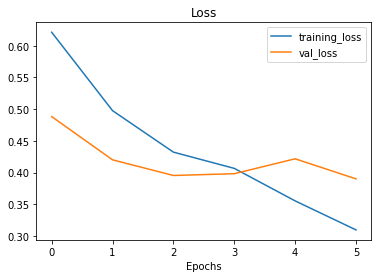

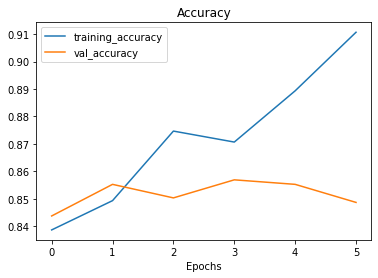

In [ ]:
# Loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

Model 4: Fine tuning model with all the data

In [ ]:
# Download all data for 10 food classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-10-31 05:18:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   200MB/s    in 2.5s    

2022-10-31 05:18:15 (200 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup dir
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test"

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.

In [ ]:
# Preprocessing data
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


We'll re-use the fine-tuned model 3 for model 4.

In [ ]:
# Check model 2 accuracy before and after fine tuning
results_10_percent_data_aug, results_fine_tune_10_percent

([0.617347776889801, 0.8432000279426575],
 [0.41397860646247864, 0.8564000129699707])

In [ ]:
# Revert back from fine-tune to non-fine-tune data by loading weights
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.6173 - accuracy: 0.8432


[0.6173475980758667, 0.8432000279426575]

Looks like we successfully reverted it back.

All we have to do is recompile and fine-tune on the full set of data.

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Fine-tune
fine_tune_epochs = initial_epochs + 5

# Fit
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20221031-063417
Epoch 5/10
235/235 [==============================] - 42s 176ms/step - loss: 0.3427 - accuracy: 0.8879 - val_loss: 0.2562 - val_accuracy: 0.9178
Epoch 6/10
235/235 [==============================] - 40s 168ms/step - loss: 0.3178 - accuracy: 0.8969 - val_loss: 0.2485 - val_accuracy: 0.9227
Epoch 7/10
235/235 [==============================] - 36s 153ms/step - loss: 0.2919 - accuracy: 0.9095 - val_loss: 0.2625 - val_accuracy: 0.9128
Epoch 8/10
235/235 [==============================] - 39s 163ms/step - loss: 0.2799 - accuracy: 0.9069 - val_loss: 0.2421 - val_accuracy: 0.9178
Epoch 9/10
235/235 [==============================] - 37s 156ms/step - loss: 0.2565 - accuracy: 0.9208 - val_loss: 0.2410 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 36s 153ms/step - loss: 0.2428 - accuracy: 0.9196 - val_loss: 0.2566 - val_accuracy: 0.9178


In [ ]:
# Evaluate
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 74ms/step - loss: 0.2553 - accuracy: 0.9176


[0.25525543093681335, 0.9175999760627747]

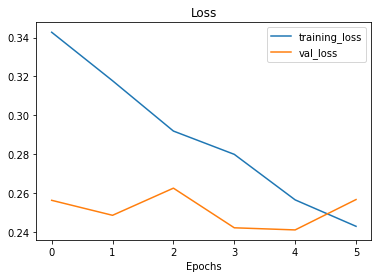

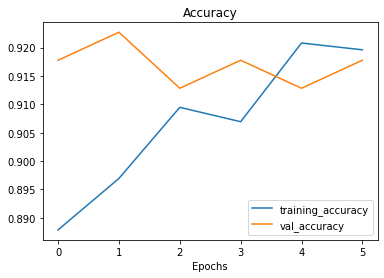

In [ ]:
plot_loss_curves(history_fine_10_classes_full)

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exit uploader once finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=cYINIIYa0MPEw7bspe9Es03kFYNEZr&prompt=consent&access_type=o

In [ ]:
# View previous experiments
!tensorboard dev list

https://tensorboard.dev/experiment/S2r6XvJzQJKzPjRx7L5d3g/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   S2r6XvJzQJKzPjRx7L5d3g
	Created              2022-10-31 06:45:18 (34 seconds ago)
	Updated              2022-10-31 06:45:23 (29 seconds ago)
	Runs                 12
	Tags                 5
	Scalars              198
	Tensor bytes         0
	Binary object bytes  5260487
Total: 1 experiment(s)


In [ ]:
# Remove this experiment
!tensorboard dev delete --experiment_id S2r6XvJzQJKzPjRx7L5d3g

Deleted experiment S2r6XvJzQJKzPjRx7L5d3g.
